In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve

file_path = 'data/raw/creditcard_2023.csv'
df = pd.read_csv(file_path).drop(columns=['id']).dropna()
df = shuffle(df)
df = df.reset_index(drop=True)

In [2]:
print(df['Class'].value_counts())  # The data is balanced

Class
1    284315
0    284315
Name: count, dtype: int64


In [3]:
print(f"Number of duplicate rows : {df.duplicated().sum()}")

df = df.drop_duplicates()

print(f"Number of duplicate rows after: {df.duplicated().sum()}")

Number of duplicate rows : 1
Number of duplicate rows after: 0


In [4]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Class' in num_features:
    num_features.remove('Class')

In [5]:
# Compute Winsorization Bounds Before Applying
winsorization_bounds = {}
for col in num_features:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    winsorization_bounds[col] = (lower, upper)

# Save Winsorization Bounds
joblib.dump(winsorization_bounds, "models/winsorization_bounds.pkl")

# Apply Winsorization Using Saved Bounds
for col, (lower, upper) in winsorization_bounds.items():
    df[col] = df[col].clip(lower=lower, upper=upper)

In [6]:
# Split Data
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
df = df.drop_duplicates()

# Split Data
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test) 


joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

In [8]:
# Convert back to DataFrame (optional, to keep feature names)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Save processed datasets
X_train.to_csv('data/processed/X_train.csv', index=False)
X_test.to_csv('data/processed/X_test.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

XGBoost Accuracy: 0.9997
XGBoost Precision: 0.9994
XGBoost Recall: 1.0000
XGBoost F1 Score: 0.9997
XGBoost ROC AUC Score: 1.0000

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56712
           1       1.00      1.00      1.00     56987

    accuracy                           1.00    113699
   macro avg       1.00      1.00      1.00    113699
weighted avg       1.00      1.00      1.00    113699

XGBoost Confusion Matrix:
 [[56678    34]
 [    0 56987]]


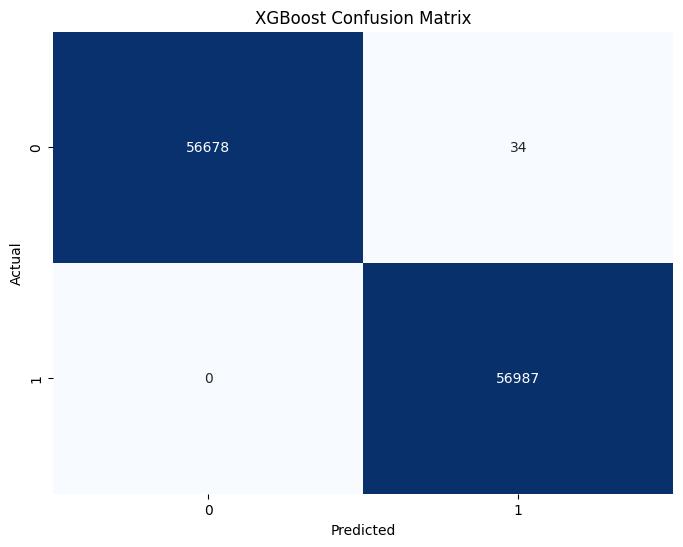

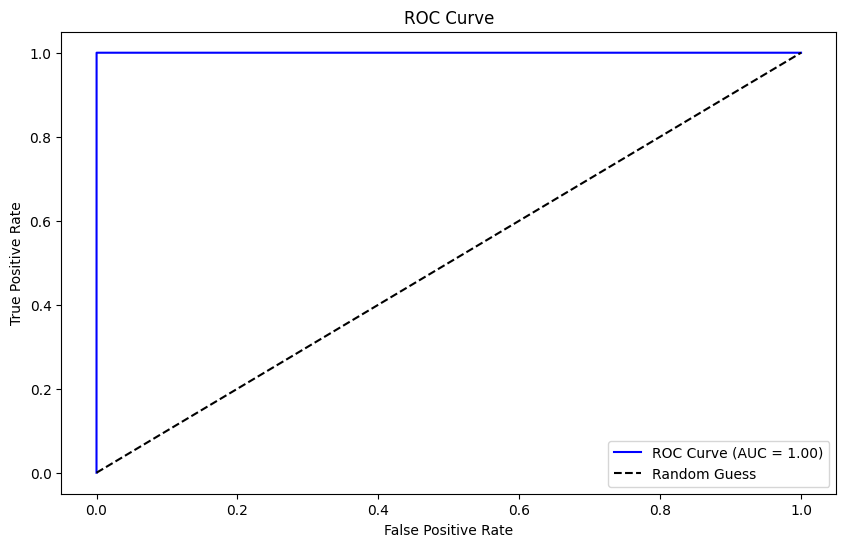

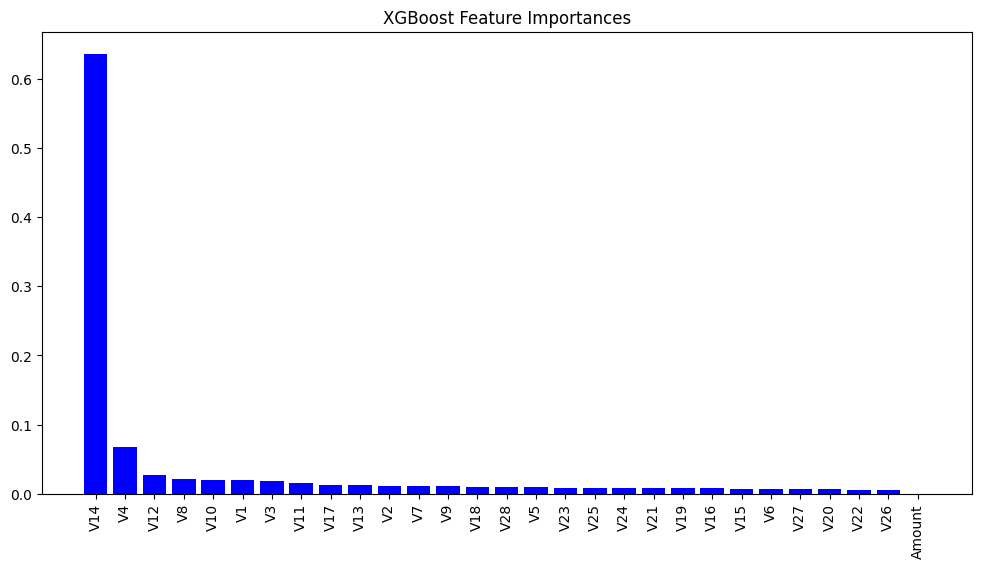

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Train XGBoost Model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'XGBoost Accuracy: {accuracy:.4f}')
print(f'XGBoost Precision: {precision:.4f}')
print(f'XGBoost Recall: {recall:.4f}')
print(f'XGBoost F1 Score: {f1:.4f}')
print(f'XGBoost ROC AUC Score: {roc_auc:.4f}')
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()



# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance Plot
importances = model.feature_importances_
sorted_features = X_train.columns[np.argsort(importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.title("XGBoost Feature Importances")
plt.bar(sorted_features, importances[np.argsort(importances)[::-1]], color='blue')
plt.xticks(rotation=90)
plt.show()


train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="XGBoost Training Accuracy")
plt.plot(train_sizes, test_mean, 'o-', label="XGBoost Test Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for XGBoost Model")
plt.legend()
plt.show()

# Save the trained model
model_filename = 'models/XGBClassifier.pkl'
joblib.dump(model, model_filename)
print(f'Model saved to {model_filename}')

Random Forest Accuracy: 0.9999
Random Forest Precision: 0.9998
Random Forest Recall: 1.0000
Random Forest F1 Score: 0.9999
Random Forest ROC AUC Score: 1.0000

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56712
           1       1.00      1.00      1.00     56987

    accuracy                           1.00    113699
   macro avg       1.00      1.00      1.00    113699
weighted avg       1.00      1.00      1.00    113699

Random Forest Confusion Matrix:
 [[56700    12]
 [    0 56987]]


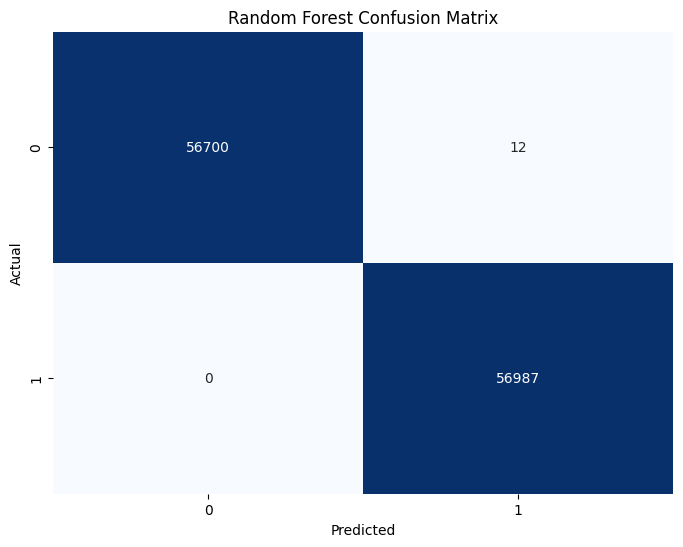

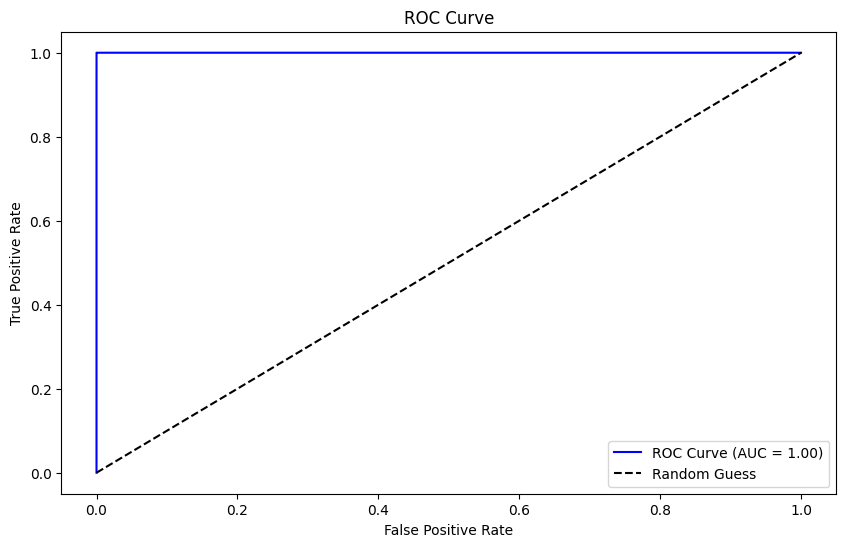

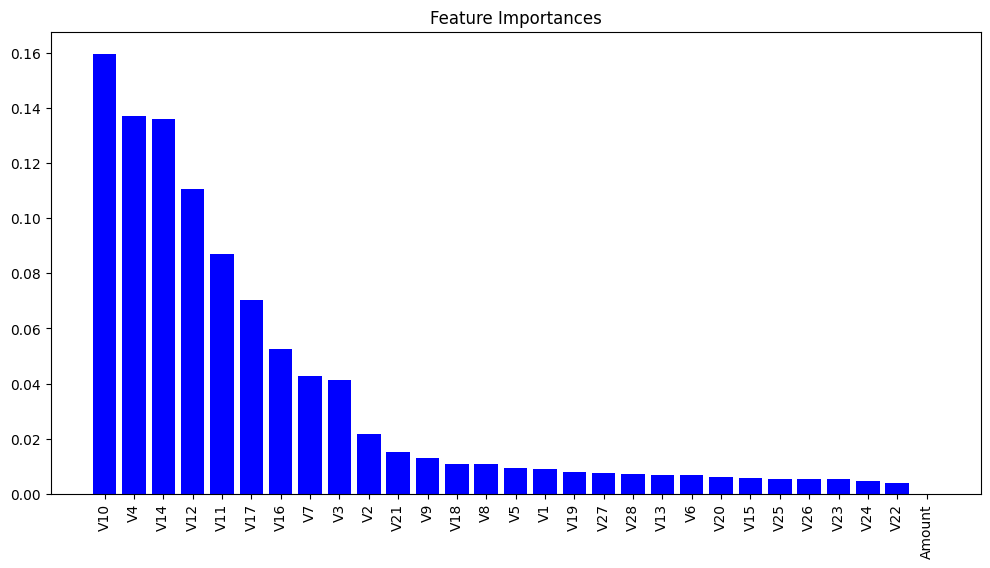

Random Forest Cross-Validation Scores : [0.99975813 0.99992304 0.99985708 0.99983509 0.99987907]
Random Forest Mean Cross-Validation Accuracy: 0.9998504818194244


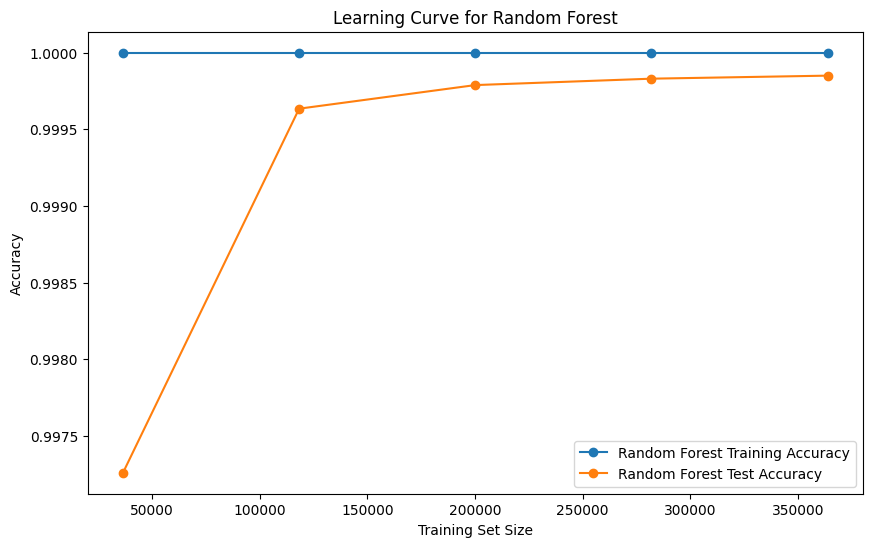

Model saved to models/RandomForestClassifier.pkl


In [10]:
# Build and Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Performance Metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Random Forest Precision: {rf_precision:.4f}')
print(f'Random Forest Recall: {rf_recall:.4f}')
print(f'Random Forest F1 Score: {rf_f1:.4f}')
print(f'Random Forest ROC AUC Score: {rf_roc_auc:.4f}')
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {rf_roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance Plot
importances = rf_model.feature_importances_
sorted_features = X_train.columns[np.argsort(importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(sorted_features, importances[np.argsort(importances)[::-1]], color='blue')
plt.xticks(rotation=90)
plt.show()

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Random Forest Cross-Validation Scores : {cv_scores}")
print(f"Random Forest Mean Cross-Validation Accuracy: {cv_scores.mean()}")


train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Random Forest Training Accuracy")
plt.plot(train_sizes, test_mean, 'o-', label="Random Forest Test Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()

# Save the trained model
model_filename = 'models/RandomForestClassifier.pkl'
joblib.dump(rf_model, model_filename)
print(f'Model saved to {model_filename}')

[LightGBM] [Info] Number of positive: 227201, number of negative: 227593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 454794, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499569 -> initscore=-0.001724
[LightGBM] [Info] Start training from score -0.001724
LightGBM Accuracy: 0.9997
LightGBM Precision: 0.9995
LightGBM Recall: 0.9999
LightGBM F1 Score: 0.9997
LightGBM ROC AUC Score: 0.9999

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56712
           1       1.00      1.00      1.00     56987

    accuracy                           1.00    113699
   macro avg       1.00      1.00      1.00    113699
weighted avg       1.00      1.00      1.00    113699

LightGBM

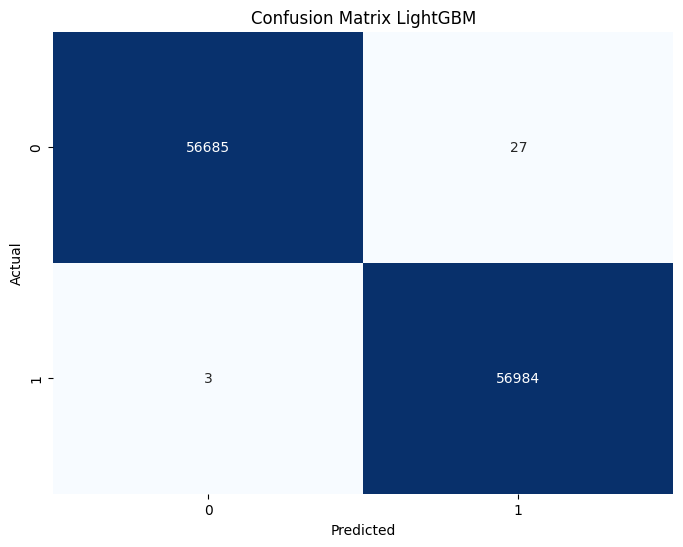

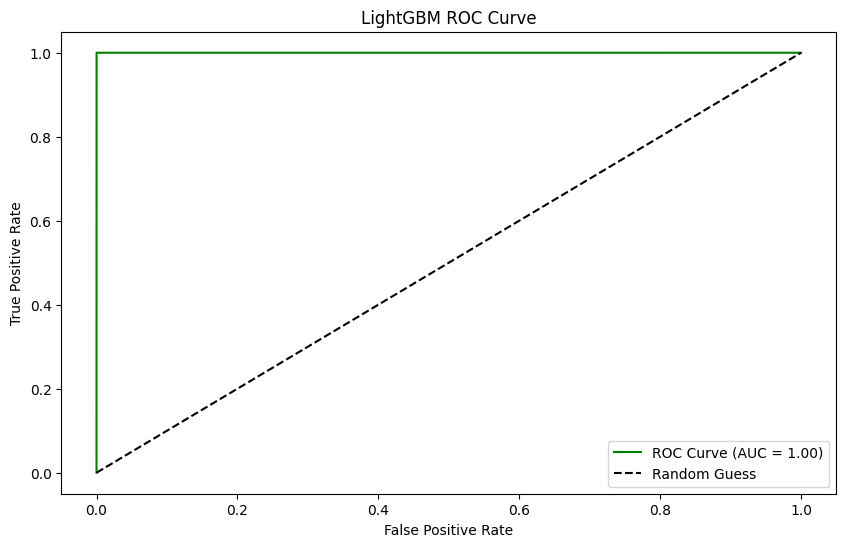

[LightGBM] [Info] Number of positive: 181761, number of negative: 182074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 363835, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499570 -> initscore=-0.001721
[LightGBM] [Info] Start training from score -0.001721
[LightGBM] [Info] Number of positive: 181761, number of negative: 182074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 363835, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499570 -> initscore=-0.001

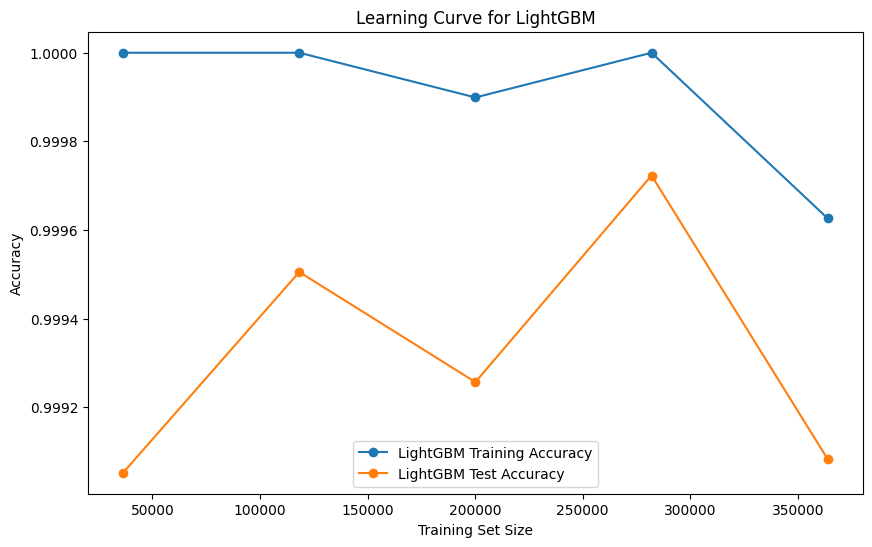

LightGBM Model saved to models/LightGBMClassifier.pkl


In [ ]:
from lightgbm import LGBMClassifier
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)

# Build and Train the LightGBM model
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,  
    learning_rate=0.05,  
    n_estimators=500,  
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Performance Metrics
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_precision = precision_score(y_test, y_pred_lgbm)
lgbm_recall = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_roc_auc = roc_auc_score(y_test, y_pred_proba_lgbm)

print(f'LightGBM Accuracy: {lgbm_accuracy:.4f}')
print(f'LightGBM Precision: {lgbm_precision:.4f}')
print(f'LightGBM Recall: {lgbm_recall:.4f}')
print(f'LightGBM F1 Score: {lgbm_f1:.4f}')
print(f'LightGBM ROC AUC Score: {lgbm_roc_auc:.4f}')
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LightGBM')
plt.show()
# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lgbm)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {lgbm_roc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend()
plt.show()


cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"LightGBM Cross-Validation Scores : {cv_scores}")
print(f"LightGBM Mean Cross-Validation Accuracy: {cv_scores.mean()}")

train_sizes, train_scores, test_scores = learning_curve(
    lgbm_model, X_train, y_train, cv=5, scoring='accuracy')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="LightGBM Training Accuracy")
plt.plot(train_sizes, test_mean, 'o-', label="LightGBM Test Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for LightGBM")
plt.legend()
plt.show()

# Save the trained LightGBM model
lgbm_model_filename = 'models/LightGBMClassifier.pkl'
joblib.dump(lgbm_model, lgbm_model_filename)
print(f'LightGBM Model saved to {lgbm_model_filename}')
